# Homework 4 - Group 20. Getting to know your customers

Group members:
* Giacomo Vittori
* Gianluca Frezza
* Jonas Barth

# Index

- [Finding Similar Customers](#1.-Finding-Similar-Costumers)
    - [Set up the data](#1.1-Set-up-the-data)
    - [Fingerprint Hashing](#1.2-Fingerprint-hashing)
    - [Locality Sensitive Hashing](#1.3-Locality-Sensitive-Hashing)

## 1. Finding Similar Costumers

Companies nowadays are implementing product suggestions to provide users with things they are likely to buy. The process often starts by finding similar behaviours among consumers; for this task, we will focus on this part in the specific.
Here you will implement an algorithm to find the most similar match to a consumer given his bank account information. In particular, you will implement your version of the LSH algorithm that takes as input information about a consumer and finds people similar to the one in the study.

## 1.1 Set up the data

First of all we used pandas to import the dataset of transaction of a bank in India. The features that could be useful to match similar consumer given the bank accont information are: CustomerID, CustomerDOB (to group by similar ages), CustGender, CustAccountBalance (to group by richness) and TransactionAmount (to group by how much money they use). We didn't use the location in which the customer do the transaction and the time of it, but we'll keep the date to calculate the age.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm as tq
from math import sqrt
import seaborn as sn
from statistics import mean
import warnings
warnings.filterwarnings("ignore")

In [130]:
df = pd.read_csv('/Users/giacomo/Desktop/locale/bank_transactions.csv', usecols = ['TransactionID', 'CustomerID', 'CustomerDOB', 'CustGender', 'TransactionDate', 'CustAccountBalance', 'TransactionAmount (INR)'])

In [3]:
df.copy()

,TransactionID,CustomerID,CustomerDOB,CustGender,CustAccountBalance,TransactionDate,TransactionAmount (INR)
0,T1,C5841053,10/1/94,F,17819.05,2/8/16,25.0
1,T2,C2142763,4/4/57,M,2270.69,2/8/16,27999.0
2,T3,C4417068,26/11/96,F,17874.44,2/8/16,459.0
3,T4,C5342380,14/9/73,F,866503.21,2/8/16,2060.0
4,T5,C9031234,24/3/88,F,6714.43,2/8/16,1762.5
...,...,...,...,...,...,...,...
1048562,T1048563,C8020229,8/4/90,M,7635.19,18/9/16,799.0
1048563,T1048564,C6459278,20/2/92,M,27311.42,18/9/16,460.0
1048564,T1048565,C6412354,18/5/89,M,221757.06,18/9/16,770.0
1048565,T1048566,C6420483,30/8/78,M,10117.87,18/9/16,1000.0


The dataset is composed by 1048567 transactions and 7 features referred to: TransactionID, CustomerID	CustomerDOB, CustGender, CustAccountBalance, TransactionDate, TransactionAmount (INR). Let's have a look into the missing values:

In [4]:
df.isna().sum()

TransactionID                 0
CustomerID                    0
CustomerDOB                3397
CustGender                 1100
CustAccountBalance         2369
TransactionDate               0
TransactionAmount (INR)       0
dtype: int64

Given that the dataset is composed by 1048567 rows the missing values are a small percentage, so we decide to drop them: 

In [5]:
df = df.dropna()

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1041765 entries, 0 to 1048566
Data columns (total 7 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   TransactionID            1041765 non-null  object 
 1   CustomerID               1041765 non-null  object 
 2   CustomerDOB              1041765 non-null  object 
 3   CustGender               1041765 non-null  object 
 4   CustAccountBalance       1041765 non-null  float64
 5   TransactionDate          1041765 non-null  object 
 6   TransactionAmount (INR)  1041765 non-null  float64
dtypes: float64(2), object(5)
memory usage: 63.6+ MB


# 1.1.1 Cust Gender

We started exploring the Gender of the customers:

In [7]:
type(df['CustGender'][0])

str

In [8]:
df['CustGender'].value_counts()

M    761098
F    280666
T         1
Name: CustGender, dtype: int64

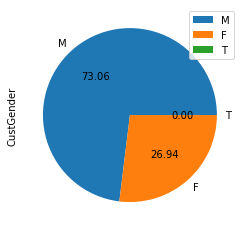

In [9]:
df['CustGender'].value_counts().plot(kind='pie', autopct='%.2f')

plt.legend()
 
plt.show()

We noticed that there is a 'T' classified gender in the dataset: 

In [10]:
df[df["CustGender"] == 'T'] 

,TransactionID,CustomerID,CustomerDOB,CustGender,CustAccountBalance,TransactionDate,TransactionAmount (INR)
959987,T959988,C3380368,1/1/1800,T,50050.0,10/9/16,32500.0


Given the big amount of transactions that we have we decided to drop it, also considering that this customer have a missing value also for the DOB. 

In [11]:
df.drop(df[df.CustGender == 'T'].index, axis=0, inplace=True)

# 1.1.2 Age

We decided to convert into datetime the date of birthday of the customers and the date of the transaction:

In [12]:
print(type(df['CustomerDOB'][0]), type(df['TransactionDate'][0]))

<class 'str'> <class 'str'>


In [13]:
df['CustomerDOB'] = pd.to_datetime(df['CustomerDOB'])

df['TransactionDate'] = pd.to_datetime(df['TransactionDate']) 

In [14]:
df.head(1)

,TransactionID,CustomerID,CustomerDOB,CustGender,CustAccountBalance,TransactionDate,TransactionAmount (INR)
0,T1,C5841053,1994-10-01,F,17819.05,2016-02-08,25.0


In [15]:
df['TransactionDate'].dt.year.value_counts()

2016    1041764
Name: TransactionDate, dtype: int64

In [16]:
df['TransactionDate'].dt.month.value_counts()

8     427368
9     157939
10     50742
7      48092
11     47036
4      46963
3      46755
6      45935
2      43510
12     42892
1      42460
5      42072
Name: TransactionDate, dtype: int64

All the data were taken in 2016, so we'll use this year to calculate the ages.
Going through the Date of Birthday we can see that there is something strange: there are dates of birthday referred to 1800, probably cause it is a default value when this data is missing, and a right tail that seems to be a part of the main figure with an offset: 

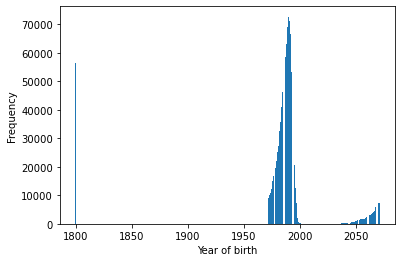

In [17]:
count = Counter(df['CustomerDOB'].dt.year)

plt.bar(count.keys(), count.values())

plt.xlabel('Year of birth')

plt.ylabel('Frequency')
 
plt.show()

In [18]:
df.loc[df['CustomerDOB'].dt.year == 1800]['CustomerDOB'].value_counts()

1800-01-01    56291
Name: CustomerDOB, dtype: int64

We decided to replace DOB referred to year 1800 with 0 age values and rearrange the data after year 2000 adjusting the offset.

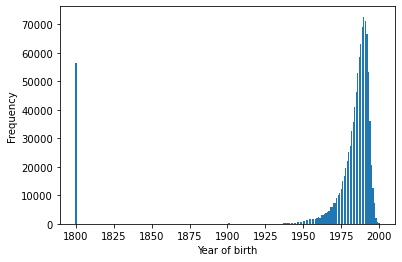

In [19]:
df.loc[df.CustomerDOB.dt.year > 2000, 'CustomerDOB'] = df.loc[df.CustomerDOB.dt.year > 2000, 'CustomerDOB'] - pd.DateOffset(years = 100)

count = Counter(df['CustomerDOB'].dt.year)

plt.bar(count.keys(), count.values())

plt.xlabel('Year of birth')

plt.ylabel('Frequency')
 
plt.show()

We created a 'CustomerAge' column filling it with 0 values:

In [20]:
df['CustomerAge'] = 0 #initialize customerAge column with 0 values

Then we substitute ages that have YOB different from 1800:

In [21]:
df.loc[df['CustomerDOB'].dt.year != 1800, 'CustomerAge'] = df.loc[df['CustomerDOB'].dt.year != 1800, 'TransactionDate'].dt.year - df.loc[df['CustomerDOB'].dt.year != 1800, 'CustomerDOB'].dt.year 

In [22]:
df['CustomerAge'] = df['CustomerAge'].astype(int)

In [23]:
del df['TransactionDate']

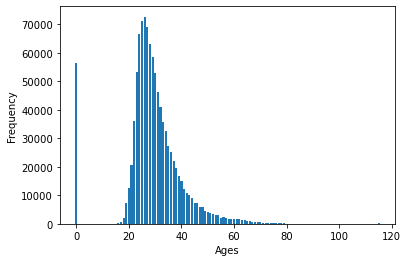

In [24]:
count = Counter(df['CustomerAge'])

plt.bar(count.keys(), count.values())

plt.xlabel('Ages')

plt.ylabel('Frequency')

plt.show()

Exploring the ages at the edges we can see that: 

In [25]:
df.loc[df['CustomerAge'] != 0]['CustomerAge'].min()

16

In [26]:
df['CustomerAge'].max()

115

Considering that the oldest person ever in India was Lucy d'Abreu who lived 113 years and 197 days (ref: Wikipedia) it seems a good choice to drop all the ages over 100 years.

In [27]:
df.drop(df[df.CustomerAge > 100].index, axis=0, inplace=True)

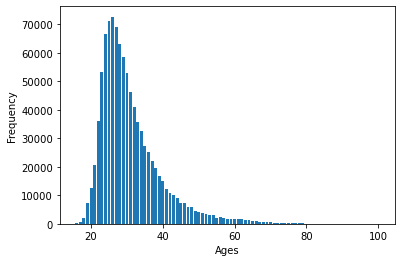

In [28]:
count = Counter(df['CustomerAge'])

count.pop(0, None)

plt.bar(count.keys(), count.values())

plt.xlabel('Ages')

plt.ylabel('Frequency')

plt.show()

In order to implement a Minhash function we decide to divide the CustomAge data in class of ages. Similar ages should led to similar interest. For this reason, looking at the distribution of ages and using our intuition, it seems to be a good choice to divide in class of 5 years from 16 to 101 (18 class):

In [29]:
bins = np.array(list(range(16, 102, 5))) #bins

def age(age):
    
    class_age = np.digitize(age, bins, right=False)  #return the number of the bin
    
    age = 'age_' + str(class_age) #class name
        
    return age

In [30]:
df['CustomerClassAge'] = df.CustomerAge.apply(lambda x: age(x)) #build the customerclass age column

In [31]:
df

,TransactionID,CustomerID,CustomerDOB,CustGender,CustAccountBalance,TransactionAmount (INR),CustomerAge,CustomerClassAge
0,T1,C5841053,1994-10-01,F,17819.05,25.0,22,age_2
1,T2,C2142763,1957-04-04,M,2270.69,27999.0,59,age_9
2,T3,C4417068,1996-11-26,F,17874.44,459.0,20,age_1
3,T4,C5342380,1973-09-14,F,866503.21,2060.0,43,age_6
4,T5,C9031234,1988-03-24,F,6714.43,1762.5,28,age_3
...,...,...,...,...,...,...,...,...
1048562,T1048563,C8020229,1990-08-04,M,7635.19,799.0,26,age_3
1048563,T1048564,C6459278,1992-02-20,M,27311.42,460.0,24,age_2
1048564,T1048565,C6412354,1989-05-18,M,221757.06,770.0,27,age_3
1048565,T1048566,C6420483,1978-08-30,M,10117.87,1000.0,38,age_5


Customer with age 0 (YOB 1800) are classified as 'CustomerClassAge' 0: 

In [32]:
df.loc[df['CustomerAge'] == 0]

,TransactionID,CustomerID,CustomerDOB,CustGender,CustAccountBalance,TransactionAmount (INR),CustomerAge,CustomerClassAge
16,T17,C1376215,1800-01-01,M,77495.15,1423.11,0,age_0
22,T23,C7018081,1800-01-01,M,143.07,110.00,0,age_0
28,T29,C7935438,1800-01-01,M,969436.12,36.90,0,age_0
35,T36,C1211387,1800-01-01,M,11791.25,1075.00,0,age_0
151,T152,C3334638,1800-01-01,M,700.00,1500.00,0,age_0
...,...,...,...,...,...,...,...,...
1048443,T1048444,C7261226,1800-01-01,M,1393.33,200.00,0,age_0
1048452,T1048453,C3813481,1800-01-01,M,984605.24,219.00,0,age_0
1048531,T1048532,C6937679,1800-01-01,M,50698.90,598.86,0,age_0
1048533,T1048534,C7431884,1800-01-01,M,53771.64,520.00,0,age_0


Age_0 will not be insterted into shingles, such that the one hot vector referred to a missing value of age will have only zeros and to not group as similar people with year of birthday 1800.

# 1.1.3 Different people with the same CustomerID

We decided to check the data related to transactions referred to the same CustomerID:

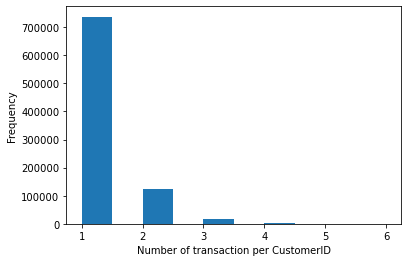

In [33]:
df.groupby('CustomerID').TransactionID.count().plot.hist()

plt.xlabel('Number of transaction per CustomerID')

plt.ylabel('Frequency')

plt.show()

In [34]:
a = df.groupby('CustomerID').TransactionID.count()  #series with number of transaction per CustomerID

df[df.CustomerID.isin(a[a > 1].index)].sort_values(by = "CustomerID") #same customer with more than one transaction

,TransactionID,CustomerID,CustomerDOB,CustGender,CustAccountBalance,TransactionAmount (INR),CustomerAge,CustomerClassAge
33670,T33671,C1010011,1992-08-19,F,32500.73,4750.00,24,age_2
173508,T173509,C1010011,1983-05-08,M,120180.54,356.00,33,age_4
251647,T251648,C1010014,1984-08-19,M,161848.76,250.00,32,age_4
89543,T89544,C1010014,1992-04-06,F,38377.14,1205.00,24,age_2
50880,T50881,C1010031,1984-07-21,M,1754.10,404.00,32,age_4
...,...,...,...,...,...,...,...,...
407803,T407804,C9094224,1980-06-24,F,10579.38,2458.00,36,age_5
673478,T673479,C9095886,1992-06-04,M,284.48,123.89,24,age_2
500536,T500537,C9095886,1991-06-19,F,27313.55,289.37,25,age_2
545604,T545605,C9096252,1991-04-03,M,9424.29,50.00,25,age_2


We can see that transactions addressed to the same CustomerID are instead related to different people but labeled with the same username. We can say that with high probability these kind of CustomerID are referred to a family or in general groups of people. We decided to threat them as different people defining a new ID based on original Customer ID, gender and ID: 

In [35]:
df['New_ID'] = df['CustomerID'] + df['CustGender'] + df['CustomerAge'].astype(str) #string concatenation

In [36]:
df[['New_ID', 'CustomerID', 'CustGender', 'CustomerAge']]

,New_ID,CustomerID,CustGender,CustomerAge
0,C5841053F22,C5841053,F,22
1,C2142763M59,C2142763,M,59
2,C4417068F20,C4417068,F,20
3,C5342380F43,C5342380,F,43
4,C9031234F28,C9031234,F,28
...,...,...,...,...
1048562,C8020229M26,C8020229,M,26
1048563,C6459278M24,C6459278,M,24
1048564,C6412354M27,C6412354,M,27
1048565,C6420483M38,C6420483,M,38


Now people labelled with same CustomerID but different ages and gender will be labelled with different CustomerID:

In [37]:
a = df.groupby('CustomerID').TransactionID.count()  #series with number of transaction per CustomerID

df[df.CustomerID.isin(a[a>1].index)][['CustomerID', 'New_ID']].sort_values(by="CustomerID") #same customer with more than one transaction

,CustomerID,New_ID
33670,C1010011,C1010011F24
173508,C1010011,C1010011M33
251647,C1010014,C1010014M32
89543,C1010014,C1010014F24
50880,C1010031,C1010031M32
...,...,...
407803,C9094224,C9094224F36
673478,C9095886,C9095886M24
500536,C9095886,C9095886F25
545604,C9096252,C9096252M25


We can see that the max number of transaction per person decreased:

In [38]:
df.groupby('New_ID').TransactionID.count().max()

3

We decided to merge togheter different transactions referred to the same ID (New_ID) taking the mean of transaction amount and of account balance. This can be done using aggregate from groupby.

In [39]:
df[df['New_ID'] == 'C1010117M29'][['New_ID', 'TransactionAmount (INR)', 'CustAccountBalance']] #example

,New_ID,TransactionAmount (INR),CustAccountBalance
214918,C1010117M29,840.0,11787.98
1027304,C1010117M29,275.0,7634.23


In [40]:
df = df.groupby('New_ID').agg({'New_ID': 'first', 'CustGender': 'first', 'CustomerAge' : 'first', 'CustomerClassAge': 'first', 'TransactionAmount (INR)': 'mean', 'CustAccountBalance': 'mean'})

In [41]:
df[df['New_ID'] == 'C1010117M29'][['New_ID', 'TransactionAmount (INR)', 'CustAccountBalance']] #example

,New_ID,TransactionAmount (INR),CustAccountBalance
New_ID,,,
C1010117M29,C1010117M29,557.5,9711.105


In [42]:
df = df.reset_index(drop = True) #reset the indexes 

In [43]:
df


,New_ID,CustGender,CustomerAge,CustomerClassAge,TransactionAmount (INR),CustAccountBalance
0,C1010011F24,F,24,age_2,4750.0,32500.73
1,C1010011M33,M,33,age_4,356.0,120180.54
2,C1010012M22,M,22,age_2,1499.0,24204.49
3,C1010014F24,F,24,age_2,1205.0,38377.14
4,C1010014M32,M,32,age_4,250.0,161848.76
...,...,...,...,...,...,...
1034947,C9099836M26,M,26,age_3,691.0,133067.23
1034948,C9099877M20,M,20,age_1,222.0,96063.46
1034949,C9099919M23,M,23,age_2,126.0,5559.75
1034950,C9099941M21,M,21,age_2,50.0,35295.92


In [44]:
df.duplicated(subset = ['New_ID']).any() #chechink for duplicates to be sure that all worked properly

False

# 1.1.5 Customer Account Balance

First of all we check the type:

In [45]:
type(df['CustAccountBalance'][0])

numpy.float64

Let's have a look to the distribution of the bank amount in function of ages:

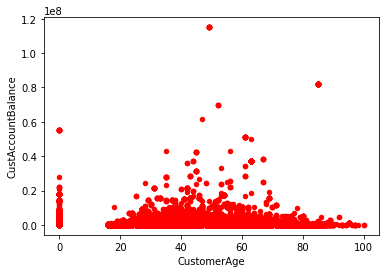

In [46]:
df[['CustAccountBalance', 'CustomerAge']].plot.scatter(x = 'CustomerAge', y = 'CustAccountBalance', c = 'red')


plt.show()

We decided to binning the CustAccountBalance through the qcut function: "The pandas documentation describes qcut as a “Quantile-based discretization function.” This basically means that qcut tries to divide up the underlying data into equal sized bins. The function defines the bins using percentiles based on the distribution of the data, not the actual numeric edges of the bins. "

In [47]:
df['CustAccountBalance'].describe()

count    1.034952e+06
mean     1.150577e+05
std      8.427398e+05
min      0.000000e+00
25%      4.754290e+03
50%      1.682766e+04
75%      5.757180e+04
max      1.150355e+08
Name: CustAccountBalance, dtype: float64

In [48]:
df['CustAccountBalance'].value_counts().sort_index()

0.000000e+00    2595
1.000000e-02     299
2.000000e-02      79
3.000000e-02      44
4.000000e-02      86
                ... 
5.536969e+07      11
6.138221e+07       1
6.979933e+07       4
8.224463e+07      18
1.150355e+08      10
Name: CustAccountBalance, Length: 164951, dtype: int64

We decide to label people with 11 classes of richness, from 0 to 10. The 'richness_0' class contains all the accounts with bank amount less than 3.37 (0-0,01 bin) that could corresponds to people which have inactive account or that do not use too much that bank account. For that reason we decided to group them togheter.

In [49]:
bin_labels = ['richness_0', 'richness_1', 'richness_2', 'richness_3', 'richness_4', 'richness_5', 'richness_6', 'richness_7', 'richness_8', 'richness_9', 'richness_10']

In [50]:
#Use qcut to put into the right bin each value of bank amount creating richness class column 

df['Richness'] = pd.qcut(df['CustAccountBalance'], q = [0,0.01, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1], labels = bin_labels)

We need to save the edges values of the bins to use them in part 1.3 of the homework:

In [51]:
query_bins_richness = np.quantile(df['CustAccountBalance'], [0,0.01, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1])

In [53]:
df.sort_values(by = 'CustAccountBalance', ascending = True)

,New_ID,CustGender,CustomerAge,CustomerClassAge,TransactionAmount (INR),CustAccountBalance,Richness
206988,C2618951F0,F,0,age_0,17196.00,0.0,richness_0
80572,C1622848M23,M,23,age_2,350.00,0.0,richness_0
941651,C8338070M42,M,42,age_6,490.00,0.0,richness_0
427475,C4328426M33,M,33,age_4,1000.00,0.0,richness_0
488009,C4817922M67,M,67,age_11,480.00,0.0,richness_0
...,...,...,...,...,...,...,...
295881,C3316830M49,M,49,age_7,28019.32,115035495.1,richness_10
423744,C4316889M49,M,49,age_7,4364.00,115035495.1,richness_10
244635,C2916887M49,M,49,age_7,600.00,115035495.1,richness_10
908942,C8116818M49,M,49,age_7,3149.00,115035495.1,richness_10


In [54]:
del df['CustAccountBalance']

# 1.1.6 Transaction Amount (INR)

Check the type:

In [55]:
type(df['TransactionAmount (INR)'][0])

numpy.float64

Let's have a look to the distribution of the transaction amount in function of ages:

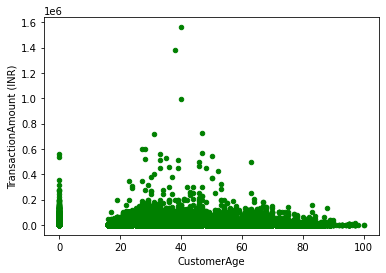

In [56]:
df[['TransactionAmount (INR)', 'CustomerAge']].plot(kind = 'scatter', x= 'CustomerAge', y = 'TransactionAmount (INR)', c = 'green')

plt.show()

In [57]:
df['TransactionAmount (INR)'].describe()

count    1.034952e+06
mean     1.566104e+03
std      6.541172e+03
min      0.000000e+00
25%      1.620000e+02
50%      4.590000e+02
75%      1.200000e+03
max      1.560035e+06
Name: TransactionAmount (INR), dtype: float64

The procedure is the same of the previous point and consists in creating a new column called 'expenditure' in which are inserted the class of 'how much does a user spend'.

In [58]:
bin_labels = ['exp_1', 'exp_2', 'exp_3', 'exp_4', 'exp_5', 'exp_6', 'exp_7', 'exp_8', 'exp_9', 'exp_10']

In [59]:
#Use qcut to create the expenditure column

df['Expenditure'] = pd.qcut(df['TransactionAmount (INR)'], q = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1], labels = bin_labels)

We need to save the values of the edges of the bin to insert into them the query in the following point:

In [60]:
query_bins_expenditure = np.quantile(df['TransactionAmount (INR)'], [0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1])

In [62]:
df.head()

,New_ID,CustGender,CustomerAge,CustomerClassAge,TransactionAmount (INR),Richness,Expenditure
0,C1010011F24,F,24,age_2,4750.0,richness_7,exp_10
1,C1010011M33,M,33,age_4,356.0,richness_9,exp_5
2,C1010012M22,M,22,age_2,1499.0,richness_6,exp_8
3,C1010014F24,F,24,age_2,1205.0,richness_7,exp_8
4,C1010014M32,M,32,age_4,250.0,richness_9,exp_4


In [63]:
del df['TransactionAmount (INR)'], df['CustomerAge']

# 1.1.7 Final Dataset

The final result is the following: 

In [64]:
df = df.reset_index(drop = True)
df

,New_ID,CustGender,CustomerClassAge,Richness,Expenditure
0,C1010011F24,F,age_2,richness_7,exp_10
1,C1010011M33,M,age_4,richness_9,exp_5
2,C1010012M22,M,age_2,richness_6,exp_8
3,C1010014F24,F,age_2,richness_7,exp_8
4,C1010014M32,M,age_4,richness_9,exp_4
...,...,...,...,...,...
1034947,C9099836M26,M,age_3,richness_9,exp_7
1034948,C9099877M20,M,age_1,richness_9,exp_4
1034949,C9099919M23,M,age_2,richness_3,exp_3
1034950,C9099941M21,M,age_2,richness_7,exp_1


In [65]:
df.to_csv('data/data.csv', sep = '\t') #save the dataset

# 1.2 Fingerprint hashing

Using the previously selected data with the features you found pertinent, you have to:

Implement your minhash function from scratch. No ready-made hash functions are allowed. Read the class material and search the internet if you need to. For reference, it may be practical to look at the description of hash functions in the book.

Process the dataset and add each record to the MinHash. The subtask's goal is to try and map each consumer to its bin; to ensure this works well, be sure you understand how MinHash works and choose a matching threshold to use. Before moving on, experiment with different thresholds, explaining your choice.

In [65]:
import pandas as pd
from tqdm import tqdm as tq
import warnings
import numpy as np
warnings.filterwarnings("ignore")

In [143]:
df = pd.read_csv("data/data.csv", sep = '\t') #load the "cleaned" dataset

In [144]:
df

,Unnamed: 0,New_ID,CustGender,CustomerClassAge,Richness,Expenditure
0,0,C1010011F24,F,age_2,richness_7,exp_10
1,1,C1010011M33,M,age_4,richness_9,exp_5
2,2,C1010012M22,M,age_2,richness_6,exp_8
3,3,C1010014F24,F,age_2,richness_7,exp_8
4,4,C1010014M32,M,age_4,richness_9,exp_4
...,...,...,...,...,...,...
1034947,1034947,C9099836M26,M,age_3,richness_9,exp_7
1034948,1034948,C9099877M20,M,age_1,richness_9,exp_4
1034949,1034949,C9099919M23,M,age_2,richness_3,exp_3
1034950,1034950,C9099941M21,M,age_2,richness_7,exp_1


In [145]:
del df['Unnamed: 0']

# 1.2.1 Shingles

First of all we build the shingles from all the unique values per column in the loaded dataset. We ignore the `TransactionID` column because it is not a shingle.

In [69]:
shingles = [] #initialize shingles
for column_name in df.columns[1:]: 
    shingles += sorted(list(df[column_name].unique())) 
    
shingles.remove('age_0')

#In order to not aggregate people who are labelled with age_0, corresponding to the Customer DOB with year 1800 
#(nan), we decided to remove age_0 from shingles such that those people will not have any 1 in the shingle matrix.
#For that reason they will not be considered similar to anyone for the age, but only for the other fields.

In [70]:
print(shingles)

['F', 'M', 'age_1', 'age_10', 'age_11', 'age_12', 'age_13', 'age_14', 'age_15', 'age_16', 'age_17', 'age_2', 'age_3', 'age_4', 'age_5', 'age_6', 'age_7', 'age_8', 'age_9', 'richness_0', 'richness_1', 'richness_10', 'richness_2', 'richness_3', 'richness_4', 'richness_5', 'richness_6', 'richness_7', 'richness_8', 'richness_9', 'exp_1', 'exp_10', 'exp_2', 'exp_3', 'exp_4', 'exp_5', 'exp_6', 'exp_7', 'exp_8', 'exp_9']


# 1.2.2 Create Shingle Matrix

First of all we create the function which maps each transaction into a vector of 0/1 based on the shingles. 

In [71]:
def one_hot_vector(data, index):
    """Creates a one hot vector for the row found in the data at the given index based on the shingles.
    
    :args
    data - a pandas dataframe containing the data.
    index - an int which corresponds to the row that will be turned into a one hot vector.
    
    :returns
    a numpy array one hot representation of the row
    """
    
    values = data.loc[index][['CustGender', 'CustomerClassAge', 'Richness', 'Expenditure']].values #extract values
    
    indeces = np.where(values.reshape(values.size, 1) == shingles)[1]  #save indexes
    
    vector = np.zeros(len(shingles), dtype = int)  #initialize vector
    
    vector[indeces] = 1  #substitute 1 in the correct positions
    
    return vector

Example:

In [73]:
df.loc[1]

New_ID              C1010011M33
CustGender                    M
CustomerClassAge          age_4
Richness             richness_9
Expenditure               exp_5
Name: 1, dtype: object

In [74]:
print(one_hot_vector(df, 1)) #one hot vector of user C1010011M33

[0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0
 0 0 0]


Now we can build a sparse matrix with all the encoded transaction. We don't need to insert into the matrix the name of the Customer cause they are linked to the index of the shingle matrix through the index of the column.  

In [76]:
shingle_matrix = np.zeros((len(df), 40), dtype = int)

for i in tq(range(len(df))):
    # Append the one hot vectors as rows
    shingle_matrix[df.index[i]] = one_hot_vector(df, i) 

# We need to transpose because for the shuffling, the Shingles need to be the rows
shingle_matrix = shingle_matrix.T

100%|███████████████████████████████| 1034952/1034952 [12:49<00:00, 1344.65it/s]


# 1.2.3 Create the Signature Matrix
From the Shingle Matrix, we will now create the signature matrix by doing the following:
1. Shuffle the rows of the Shingle Matrix.
1. Create a vector where each element corresponds to the index of the row of each column (Shingle) where the first 1 is found.
1. Append this vector to the Signature Matrix.
1. Repeat $n$ times.

The goal of the MinHash is to replace a large set with a smaller "signature" that still preserves the underlying similarity metric.

In [80]:
n_permutations = 20 #number of permutations = number of rows of the signature matrix
signature_matrix = np.zeros((20, shingle_matrix.shape[1]), dtype = int) #initialize signature matrix
seed = np.random.randint(0, 100000)
np.random.seed(seed) #set seed for reproducibility

In [81]:
for i in tq(range(n_permutations)):
    # 1. Shuffle rows
    np.random.shuffle(shingle_matrix)
    
    # 2. Create the vector of indeces where the first 1 is found. np.argmax stops at the first occurrence
    signature_row = np.argmax(shingle_matrix == 1, axis=0) + 1
    
    # 3. Add to signature matrix
    signature_matrix[i] = signature_row

100%|███████████████████████████████████████████| 20/20 [00:34<00:00,  1.72s/it]


In [82]:
signature_matrix

array([[17, 14, 16, ..., 16, 16, 16],
       [ 9, 11, 23, ...,  6,  2,  3],
       [ 9, 14, 27, ...,  7, 13, 14],
       ...,
       [ 7, 17,  8, ...,  8,  3, 16],
       [24,  3, 10, ...,  6, 20,  7],
       [ 2,  1,  1, ...,  1,  1,  1]])

In [83]:
signature_matrix.shape

(20, 1034952)

The index of the column can be referred to the customer ID looking at the index of the initial dataframe: 

In [84]:
df

,New_ID,CustGender,CustomerClassAge,Richness,Expenditure
0,C1010011F24,F,age_2,richness_7,exp_10
1,C1010011M33,M,age_4,richness_9,exp_5
2,C1010012M22,M,age_2,richness_6,exp_8
3,C1010014F24,F,age_2,richness_7,exp_8
4,C1010014M32,M,age_4,richness_9,exp_4
...,...,...,...,...,...
1034947,C9099836M26,M,age_3,richness_9,exp_7
1034948,C9099877M20,M,age_1,richness_9,exp_4
1034949,C9099919M23,M,age_2,richness_3,exp_3
1034950,C9099941M21,M,age_2,richness_7,exp_1


For example the first column of the signature matrix is referred to the customer C1010011F24.

# 1.2.4 Divide Signature Matrix into Bands

The example signature matrix below is divided into $b$ bands of $r$ rows each, and each band is hashed separately. For this example, we are setting band , which means that we will consider any titles with the same first two rows to be similar. The larger we make b the less likely there will be another Paper that matches all of the same permutations.

![signature_matrix_into_bands](https://storage.googleapis.com/lds-media/images/locality-sensitive-hashing-lsh-buckets.width-1200.png)

The $\textit{probability}$ that the minhash function for a random permutation of rows produces the $\textbf{same values}$ for two sets is equal to the $\textbf{Jaccard similarity}$ of those sets.


The size of the bands control the probability that two items with a given Jaccard similarity end up in the same bucket. If the number of bands is larger, you will end up with much smaller sets. For instance, $b = p$, where $p$ is the number of permutations (i.e. rows in the signature matrix) would almost certainly lead to $N$ buckets of only one item because there would be only one item that was perfect similar across every permutation.

In order to create the buckets we decide to create a dictionary that will have the sub_vector as keys and the indexes of the column where they are found as values. These indexes will allow us to substistute the related customer:

In [85]:
def create_buckets(b, signature):
    
    indexes = list(range(signature.shape[1])) #create a list of indexes 

    signature_matrix_transposed = signature.T #transpose the matrix to get subvectors column

    cluster = {} #initialize the dictionary containing as keys the subvector and as values the indexes of the customer

    for i in tq(range(0, signature.shape[0], b)):  #iterate over the row with step size equal to bandsize
    
        #take the subvector of dimension i, i+b (band size) from the column
        mini_vectors = signature_matrix_transposed[:, i:i+b] 
    
    # sorts the subvectors associated to the indexes to maintain the relationship with the index of the customers.
    # We use a tuple instead of a list because tuples can be hashable and therefore 
    # usable as keys for dictionaries. Sorting will allow us to have the same subvector as neighbors
    
        c = [(i, tuple(v)) for v, i in sorted(zip(mini_vectors.tolist(), indexes))]
    
        curr_vector = c[0][1] #take the subvector from the tuple composed by index and subvector
    
    #Now we have equal subvector as neighbor, so we can iterate over these groups of equal subvector
        for i, v in c:  
        
            if v not in cluster: #if the subvector is not a key in the cluster --> initialize it 
            
                cluster[v] = []
        
            if curr_vector != v: #when the iteration go over the group of equal subvector updtate the current vector
            
                curr_vector = v

            cluster[v].append(i) #append as values the indexes where that subvector is found 
    
    return cluster

We can create a dictionary containing the buckets with band size 4:

In [86]:
cluster_4 = create_buckets(4, signature_matrix)

100%|█████████████████████████████████████████████| 5/5 [00:26<00:00,  5.34s/it]


We can see that the keys are the subvector:

In [87]:
print(list(cluster_4.keys())[:5])

[(1, 4, 1, 1), (1, 4, 1, 13), (1, 4, 2, 1), (1, 4, 2, 13), (1, 4, 6, 1)]


And the values are the column index where they've been found:

In [88]:
cluster_4[list(cluster_4.keys())[0]][0:5]  #first 5 index referred to the first key of the dictionary:

[810, 4964, 6058, 7325, 9634]

Through them we can recover the name of the customers defining a function that substitute the values of each keys with the 'New_ID' value in the dataframe:

In [89]:
def substitute_keys(buckets, data):
    
    for key in list(buckets.keys()):
    
        buckets[key] = data.loc[buckets[key]]['New_ID'].to_list() #subtitute the indexes with the customers name

    return buckets

In [90]:
cluster_4 = substitute_keys(cluster_4, df)

We can see that now the values of each key are the customer name:

In [91]:
cluster_4[list(cluster_4.keys())[0]][0:5]

['C1012563M20', 'C1024912M20', 'C1028262M20', 'C1032276M20', 'C1039184M20']

We can now visually check how much similar the customer in a bucket are:

In [92]:
df[df['New_ID'].isin(cluster_4[list(cluster_4.keys())[0]])] 

,New_ID,CustGender,CustomerClassAge,Richness,Expenditure
810,C1012563M20,M,age_1,richness_4,exp_4
4964,C1024912M20,M,age_1,richness_4,exp_4
6058,C1028262M20,M,age_1,richness_4,exp_4
7325,C1032276M20,M,age_1,richness_4,exp_4
9634,C1039184M20,M,age_1,richness_4,exp_4
...,...,...,...,...,...
1030000,C9033312M20,M,age_1,richness_4,exp_4
1030481,C9034785M18,M,age_1,richness_4,exp_4
1030514,C9034858M20,M,age_1,richness_4,exp_4
1031887,C9039191M20,M,age_1,richness_4,exp_4


And the number of bucket that we have: 

In [93]:
len(cluster_4)

4798

We can now visually check what happen for $\textbf{band size = 2}$:

In [94]:
cluster_2 = create_buckets(2, signature_matrix) #create buckets with band size 2

cluster_2 = substitute_keys(cluster_2, df) #substitute index with customer names

print('The number of buckets is ', len(cluster_2))

df[df['New_ID'].isin(cluster_2[list(cluster_2.keys())[0]])] #show the member of a bucket as example

100%|███████████████████████████████████████████| 10/10 [01:10<00:00,  7.08s/it]


The number of buckets is  599


,New_ID,CustGender,CustomerClassAge,Richness,Expenditure
5,C1010018F26,F,age_3,richness_1,exp_1
7,C1010028F28,F,age_3,richness_10,exp_6
10,C1010035M24,M,age_2,richness_4,exp_1
19,C1010045M29,M,age_3,richness_4,exp_4
55,C1010157M24,M,age_2,richness_4,exp_1
...,...,...,...,...,...
1034926,C9099142M46,M,age_7,richness_4,exp_9
1034930,C9099183M25,M,age_2,richness_4,exp_1
1034943,C9099740M24,M,age_2,richness_4,exp_6
1034946,C9099832M32,M,age_4,richness_4,exp_6


Decreasing the size of the bands the number of buckets decrease cause are grouped togheter customer that have different values in some fields.

Checking what happen with $\textbf{band size = 5}$:

In [95]:
cluster_5 = create_buckets(5, signature_matrix) #create buckets with band size 2

cluster_5 = substitute_keys(cluster_5, df) #substitute index with customer names

print('The number of buckets is ', len(cluster_5))

df[df['New_ID'].isin(cluster_5[list(cluster_5.keys())[0]])] 

100%|█████████████████████████████████████████████| 4/4 [00:41<00:00, 10.34s/it]


The number of buckets is  6110


,New_ID,CustGender,CustomerClassAge,Richness,Expenditure
810,C1012563M20,M,age_1,richness_4,exp_4
4964,C1024912M20,M,age_1,richness_4,exp_4
6058,C1028262M20,M,age_1,richness_4,exp_4
7325,C1032276M20,M,age_1,richness_4,exp_4
9634,C1039184M20,M,age_1,richness_4,exp_4
...,...,...,...,...,...
1030000,C9033312M20,M,age_1,richness_4,exp_4
1030481,C9034785M18,M,age_1,richness_4,exp_4
1030514,C9034858M20,M,age_1,richness_4,exp_4
1031887,C9039191M20,M,age_1,richness_4,exp_4


There is a larger number of bucket (so a less number of customer per bucket) and the customers have all the same values in the different fields.  

So, the choice of the band size $depends$ on how much similar customer do you want in your bucket. Supposing our request is not too restrictive we can choose $\textbf{4 as band size}$ to execute the query for the next point. 

# 1.3 Locality Sensitive Hashing

Now that you prepared your algorithm, it's query time!
We have prepared some dummy users for you to work with.

Download this csv and report the most similar users (comparing them against the dataset provided in Kaggle).
Did your hashing method work properly, what scores have you obtained and how long did it take to run? Provide information and analysis about the results

# 1.3.1 Pre-processing Query dataset

First of all we need to pre-process the query dataset in the same way we pre-process the initial Kaggle dataset dividing the procedure in the following steps: 

    - Create classes through the ages
    
    - Create classes through the bank amount
    
    - Create classes through the transaction amount
    
    - Create a name for the customers

In [146]:
query = pd.read_csv("query_users/query_users.csv")

In [147]:
query.head()

,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,27/7/78,M,DELHI,94695.61,2/9/16,140310,65.0
1,6/11/92,M,PANCHKULA,7584.09,2/9/16,120214,6025.0
2,14/8/91,M,PATNA,7180.60,10/8/16,221732,541.5
3,3/1/87,M,CHENNAI,56847.75,29/8/16,144138,1000.0
4,4/1/95,M,GURGAON,84950.13,25/9/16,233309,80.0


In [148]:
del query['CustLocation'], query['TransactionTime'] #Delete the data that we don't need 

First of all we convert them into class of age, richness and expenditure.

### Customer Class Age

Starting with the age, we used the same procedure of point 1.1:

In [149]:
#In order to calculate the ages we need to transform into datetime birthday and year of the transactions

query['CustomerDOB'] = pd.to_datetime(query['CustomerDOB']) 

query['TransactionDate'] = pd.to_datetime(query['TransactionDate'])

query['CustomerAge'] = 0 #initialize with values zero the ages

#give an age only to queries that have a different YOB from 1800
query.loc[query['CustomerDOB'].dt.year != 1800, 'CustomerAge'] = query.loc[query['CustomerDOB'].dt.year != 1800, 'TransactionDate'].dt.year - query.loc[query['CustomerDOB'].dt.year != 1800, 'CustomerDOB'].dt.year 

In [150]:
query.head(5)

,CustomerDOB,CustGender,CustAccountBalance,TransactionDate,TransactionAmount (INR),CustomerAge
0,1978-07-27,M,94695.61,2016-02-09,65.0,38
1,1992-06-11,M,7584.09,2016-02-09,6025.0,24
2,1991-08-14,M,7180.60,2016-10-08,541.5,25
3,1987-03-01,M,56847.75,2016-08-29,1000.0,29
4,1995-04-01,M,84950.13,2016-09-25,80.0,21


In [151]:
del query['TransactionDate'], query['CustomerDOB'] #deleting the data that we don't need

We $\textit{binned the ages}$ into the same classes of point 1.1, using the function $"\textbf{age}"$: 

In [152]:
bins = np.array(list(range(16, 102, 5)))  #bins

query['CustomerClassAge'] = query.CustomerAge.apply(lambda x: age(x)) #build a new column called class age

In [153]:
del query['CustomerAge'] #deleting the column with the ages

In [154]:
query.head()

,CustGender,CustAccountBalance,TransactionAmount (INR),CustomerClassAge
0,M,94695.61,65.0,age_5
1,M,7584.09,6025.0,age_2
2,M,7180.60,541.5,age_2
3,M,56847.75,1000.0,age_3
4,M,84950.13,80.0,age_2


### Richness

In this case we cannot use the quantiles function 'qcut' to divide into bins the account balance of the customer cause it will be a different results from the classes of the point 1.1. For this reason we used the bins that we saved in point 1.1 and the $\textit{function pd.cut}$ that binned the values with the bins we insert labelling them with the names of the classes. 

In [155]:
bin_labels = ['richness_0', 'richness_1', 'richness_2', 'richness_3', 'richness_4', 'richness_5', 'richness_6', 'richness_7', 'richness_8', 'richness_9', 'richness_10']

We recalled from memory the bins of the classes of richness:

In [157]:
#create the column with the classes of richness:

query['Richness'] = pd.cut(query.CustAccountBalance, bins = query_bins_richness, labels=bin_labels, right=False)

In [158]:
del query['CustAccountBalance'] #deleting the column that we don't need

In [159]:
query.head() #check the result

,CustGender,TransactionAmount (INR),CustomerClassAge,Richness
0,M,65.0,age_5,richness_9
1,M,6025.0,age_2,richness_4
2,M,541.5,age_2,richness_4
3,M,1000.0,age_3,richness_8
4,M,80.0,age_2,richness_9


### Expenditure

We repeated the same procedure of the richness for the expenditure class:

In [161]:
#create the column expenditure

bin_labels = ['exp_1', 'exp_2', 'exp_3', 'exp_4', 'exp_5', 'exp_6', 'exp_7', 'exp_8', 'exp_9', 'exp_10']

query['Expenditure'] = pd.cut(query['TransactionAmount (INR)'], bins = query_bins_expenditure, labels=bin_labels, right=False)

In [162]:
del query['TransactionAmount (INR)'] #deleting the column that we don't need

In [163]:
query.head() #check the result

,CustGender,CustomerClassAge,Richness,Expenditure
0,M,age_5,richness_9,exp_2
1,M,age_2,richness_4,exp_10
2,M,age_2,richness_4,exp_6
3,M,age_3,richness_8,exp_8
4,M,age_2,richness_9,exp_2


### Giving a Name to Query-Customer

The last step that we decided to make is to give a name to this customer -> Query_User_i where i goes from 0 to 49:

In [164]:
#create two column and combine them to create the name:

query['sub'] = 'Query_User_' #prefix

query['num'] = range(50) #numbers

query['New_ID'] = query['sub'] + query['num'].astype(str) #concatenating prefix and number

del query['num'], query['sub'] #deleting the prefix and the numbers

In [165]:
query = query[['New_ID', 'CustGender', 'CustomerClassAge', 'Richness', 'Expenditure']] #reorder the column

In [166]:
query.head() #cheching the result query dataset

,New_ID,CustGender,CustomerClassAge,Richness,Expenditure
0,Query_User_0,M,age_5,richness_9,exp_2
1,Query_User_1,M,age_2,richness_4,exp_10
2,Query_User_2,M,age_2,richness_4,exp_6
3,Query_User_3,M,age_3,richness_8,exp_8
4,Query_User_4,M,age_2,richness_9,exp_2


# 1.3.2 Execute the query

$\textbf{Procedure:}$

To execute the query and return as output the most similar customer to each query we need to do the same MinHash procedure with the same type of shuffling to the rows. Such that the algorithm to divide into bucket is fast (less than 40 seconds) we decided to concatenate the new shingle matrix (shingle query) to the shingle matrix of the initial dataset and to re-execute the bucket-creation procedure. Then we will create a function that takes as input the the name of the query and gives as output the buckets that contain the most similar users to him. 

### Shingle matrix for the query

First of all we define the shingles:

In [167]:
shingles = ['F', 'M', 'age_1', 'age_10', 'age_11', 'age_12', 'age_13', 'age_14', 'age_15', 'age_16', 'age_17', 'age_2', 'age_3', 'age_4', 'age_5', 'age_6', 'age_7', 'age_8', 'age_9', 'richness_0', 'richness_1', 'richness_10', 'richness_2', 'richness_3', 'richness_4', 'richness_5', 'richness_6', 'richness_7', 'richness_8', 'richness_9', 'exp_1', 'exp_10', 'exp_2', 'exp_3', 'exp_4', 'exp_5', 'exp_6', 'exp_7', 'exp_8', 'exp_9']

We build the $\textit{"shingle query"}$ using the 'one_hot_vector' function:

In [168]:
shingle_query = np.zeros((len(query), 40), dtype = int)

for i in tq(range(len(query))):
    # Append the one hot vectors as rows
    shingle_query[query.index[i]] = one_hot_vector(query, i) 

# We need to transpose because for the shuffling, the Shingles need to be the rows
shingle_query = shingle_query.T

100%|█████████████████████████████████████████| 50/50 [00:00<00:00, 1002.42it/s]


An example to see if it worked properly:

In [169]:
query.loc[1]

New_ID              Query_User_1
CustGender                     M
CustomerClassAge           age_2
Richness              richness_4
Expenditure               exp_10
Name: 1, dtype: object

In [170]:
print(shingles)

['F', 'M', 'age_1', 'age_10', 'age_11', 'age_12', 'age_13', 'age_14', 'age_15', 'age_16', 'age_17', 'age_2', 'age_3', 'age_4', 'age_5', 'age_6', 'age_7', 'age_8', 'age_9', 'richness_0', 'richness_1', 'richness_10', 'richness_2', 'richness_3', 'richness_4', 'richness_5', 'richness_6', 'richness_7', 'richness_8', 'richness_9', 'exp_1', 'exp_10', 'exp_2', 'exp_3', 'exp_4', 'exp_5', 'exp_6', 'exp_7', 'exp_8', 'exp_9']


In [171]:
shingle_query[:, 1]

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0])

Then we concatenate the shingle query matrix to the initial shingle matrix: 

In [173]:
new_shingle_matrix = np.concatenate((shingle_matrix, shingle_query), axis = 1) #concatenate the two matrix

In [174]:
new_shingle_matrix.shape

(40, 1035002)

### Create the new signature matrix

Now we can repeat the same MinHash procedure to build the signature matrix: 

In [175]:
n_permutations = 20 #number of permutations = number of rows of the signature matrix

new_signature_matrix = np.zeros((20, new_shingle_matrix.shape[1]), dtype = int) #initialize signature matrix

for i in tq(range(n_permutations)):
    # 1. Shuffle rows
    np.random.shuffle(new_shingle_matrix)
    
    # 2. Create the vector of indeces where the first 1 is found. np.argmax stops at the first occurrence
    signature_row = np.argmax(new_shingle_matrix == 1, axis=0) + 1
    
    # 3. Add to signature matrix
    new_signature_matrix[i] = signature_row


100%|███████████████████████████████████████████| 20/20 [00:34<00:00,  1.70s/it]


To use the "$\textit{substitute_keys}$" function we need to concatenate to the initial dataframe the data related to the query: 

In [176]:
df = df.append(query, ignore_index = True) #append query dataframe to the initial dataframe

In [177]:
df

,New_ID,CustGender,CustomerClassAge,Richness,Expenditure
0,C1010011F24,F,age_2,richness_7,exp_10
1,C1010011M33,M,age_4,richness_9,exp_5
2,C1010012M22,M,age_2,richness_6,exp_8
3,C1010014F24,F,age_2,richness_7,exp_8
4,C1010014M32,M,age_4,richness_9,exp_4
...,...,...,...,...,...
1034997,Query_User_45,F,age_3,richness_10,exp_4
1034998,Query_User_46,M,age_6,richness_6,exp_2
1034999,Query_User_47,M,age_2,richness_10,exp_2
1035000,Query_User_48,F,age_2,richness_4,exp_8


### Buckets creation

We choose the band size b and then we can created the dictionary with the buckets:

In [180]:
cluster_query = create_buckets(4, new_signature_matrix) #create buckets with band size 4

cluster_query = substitute_keys(cluster_query, df) #substitute index with customer names

print('The number of buckets is ', len(cluster_query))

df[df['New_ID'].isin(cluster_query[list(cluster_query.keys())[0]])] #show as example the first group of similar customers

100%|█████████████████████████████████████████████| 5/5 [00:52<00:00, 10.44s/it]


The number of buckets is  4679


,New_ID,CustGender,CustomerClassAge,Richness,Expenditure
6913,C1031019M57,M,age_9,richness_7,exp_8
10075,C1040536F60,F,age_9,richness_7,exp_8
10638,C1042285F60,F,age_9,richness_7,exp_8
17829,C1125238M56,M,age_9,richness_7,exp_8
25721,C1210613F58,F,age_9,richness_7,exp_8
...,...,...,...,...,...
987429,C8721514F56,F,age_9,richness_7,exp_8
1011667,C8917230M57,M,age_9,richness_7,exp_8
1014438,C8925228M56,M,age_9,richness_7,exp_8
1024523,C9017164F59,F,age_9,richness_7,exp_8


### Search the buckets where the query is included

We created a function that takes as $\textbf{input}$ the name of the query (e.g. $\textit{Query_user_35}$) and gives as $\textbf{output}$ the keys of the buckets in which it's contained(e.g. $\textit{Query_user_35: [(1,1,1,2), (1,3,4,3), ...]}$):

In [181]:
def search_bucket(name):
    
    index = [] #initialize the list where will be inserted the keys where the name is found
    
    keys = list(cluster_query.keys()) #list of keys of the dictionary containing the buckets

    values = list(cluster_query.values()) #list of values of the dictionary containing the buckets
    
    #values is a list of lists where the inner contains the values related to the keys.

    for i, v in enumerate(values): # i -> index of the keys, v -> list of values
        
        if name in v:
            
            index.append(keys[i]) #append the keys where the name is found using the index
            
    return index #return the list of keys

Now we decided to create a $\textbf{dictionary}$ where we store as $keys$ the name of the query customer and as $values$ a list of buckets keys where the query customer is inserted. Through them we can find groups of customer similar to the queries: 

In [183]:
# Creation of a dictionary where all the info about the similar users to all the queries all inserted: 

# Keys   -> Query names (e.g. 'Query_User_2', 'Query_User_41', ...)

# Values -> List of keys, i.e. The link to the buckets (e.g. [(9, 4, 8, 12), (21, 20, 19, 10), ...] )

query_buckets = {} #initialize query_bucket

queries_name = list(df.iloc[-50:]['New_ID']) #list of query customer name

for q in queries_name:
    
    query_buckets[q] = search_bucket(q) #keys = query customer name, values = list of bucket where it's found

Example: 

In [186]:
print(query_buckets['Query_User_32'])

[(9, 4, 8, 12), (21, 20, 19, 10), (7, 14, 5, 10), (11, 4, 12, 5), (8, 2, 9, 9)]


The work is done! 

### Find the similar customers gived the query_name

We decided to create a function $\textit{similar_to_query}$ that takes as $\textbf{input}$ the name of the query (e.g. $\textit{Query_User_43})$ and gives as $\textbf{output}$ the components of all the different $\textit{clusters}$ where this users is inserted. In the follow lines we can see an example on how it works:

In [187]:
def similar_to_query(query_name):
    
    keys = query_buckets[query_name] #list of bucket keys of where the name is found
    
    similar_customers = {}  #initialize a dict: keys = name of the group, values = similar customer to the query
    
    for i,k in enumerate(keys):
        
        similar_customers['Group_' + str(i)] = cluster_query[k] #build the dictionary
       
    return similar_customers

In [190]:
similar_to_34 = similar_to_query('Query_User_34')

In [199]:
print(similar_to_34['Group_2'][0:5]) #first 5 components of the second group of similar customer to query_user_34

['C1010876F30', 'C1010921F28', 'C1011387F30', 'C1011643F26', 'C1012035F30']


For example we can take one of the members of a group and compare them to the query user: 

In [192]:
df[df['New_ID'] == 'Query_User_34']

,New_ID,CustGender,CustomerClassAge,Richness,Expenditure
1034986,Query_User_34,M,age_2,richness_10,exp_10


In [193]:
df[df['New_ID'].isin(similar_to_query('Query_User_34')['Group_3'])] 

,New_ID,CustGender,CustomerClassAge,Richness,Expenditure
1034953,Query_User_1,M,age_2,richness_4,exp_10
1034986,Query_User_34,M,age_2,richness_10,exp_10
